In [14]:
# ==========================================
# 1. DATENVORBEREITUNG (für alle Schadstoffe)
# ==========================================
# (Angenommen, dein DataFrame heißt df und wurde bereits eingelesen, 
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping der Spaltennamen anwenden
rename_dict = {
    "Stationscode": "code",
    "Stationsname": "name",
    "Stationsumgebung": "area",
    "Art der Station": "type",
    "Timestamp": "timestamp",
    "Einheit": "unit",
    "Feinstaub (PM₁₀)": "pm10",
    "Feinstaub (PM₂,₅)": "pm25",
    "Kohlenmonoxid (CO)": "co",
    "Ozon (O₃)": "o3",
    "Schwefeldioxid (SO₂)": "so2",
    "Stickstoffdioxid (NO₂)": "no2"
}

data_path = Path.cwd() / "Luftqualitaet_Zusammenfassung.csv"
df = pd.read_csv(data_path, encoding="UTF-8", sep=";")

# Benenne die Spalten im DataFrame um
df.rename(columns=rename_dict, inplace=True)

# Stelle sicher, dass timestamp ein Datetime-Objekt ist
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["time"] = df["timestamp"].dt.time
df["date"] = df["timestamp"].dt.date

# Definiere deine Schadstoff-Spalten (jetzt inklusive 'co')
pollutant_cols = ["pm10", "pm25", "co", "o3", "so2", "no2"]

df = df.drop(columns=["co"])

# to numeric, coerce errors to NaN
pollutant_cols = ["pm10", "pm25", "o3", "so2", "no2"]
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Berechne den Tagesmittelwert für ALLE Schadstoffe auf einmal
# Wir gruppieren nach dem genauen Datum (ohne Uhrzeit)
daily_data = df.groupby(df["timestamp"].dt.date)[pollutant_cols].mean().reset_index()


# Spalte wieder in ein sauberes Datetime-Format umwandeln und umbenennen
daily_data.rename(columns={"timestamp": "Datum"}, inplace=True)
daily_data["Datum"] = pd.to_datetime(daily_data["Datum"])

# Extrahiere Monat und Tag für das Raster
daily_data["Monat"] = daily_data["Datum"].dt.month
daily_data["Tag"] = daily_data["Datum"].dt.day

# Mappe die Monatszahlen auf echte Monatsnamen
monatsnamen = {
    1: "Januar", 2: "Februar", 3: "März", 4: "April", 
    5: "Mai", 6: "Juni", 7: "Juli", 8: "August", 
    9: "September", 10: "Oktober", 11: "November", 12: "Dezember"
}

/var/folders/1y/b928j3z917s1tz2f3wl_3m5r0000gn/T/ipykernel_1911/3266182168.py:28: DtypeWarning: Columns (0: Feinstaub (PM₂,₅), 1: Kohlenmonoxid (CO), 2: Ozon (O₃), 3: Schwefeldioxid (SO₂)) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding="UTF-8", sep=";")


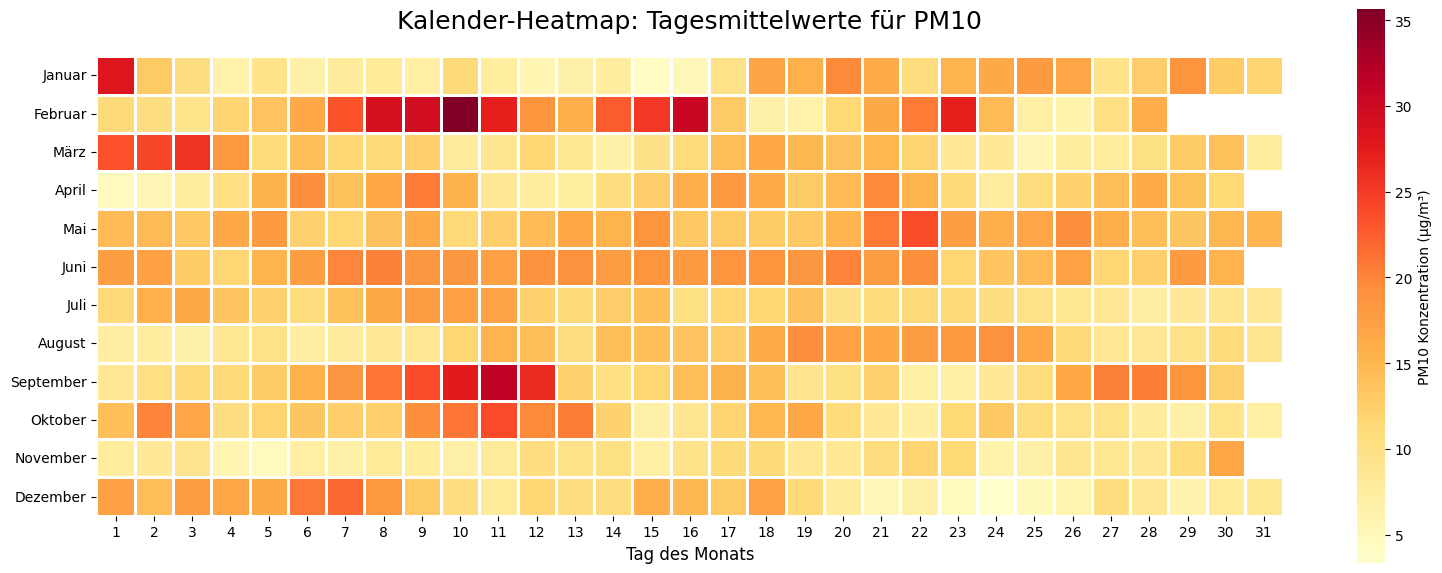

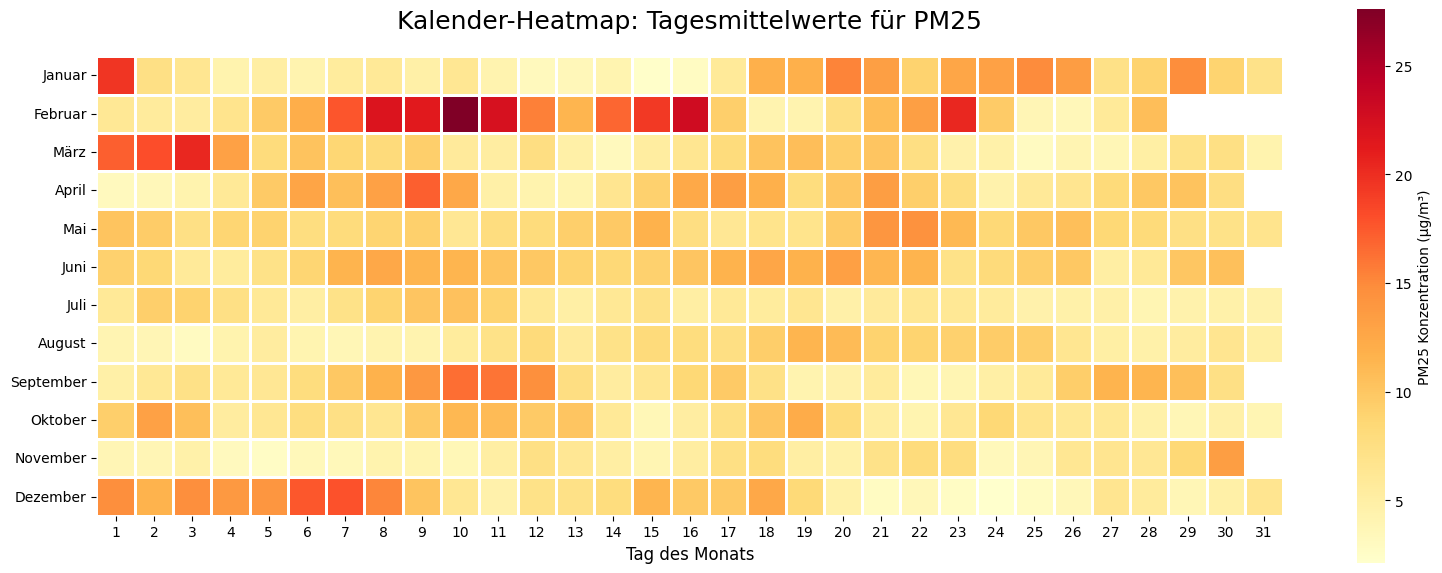

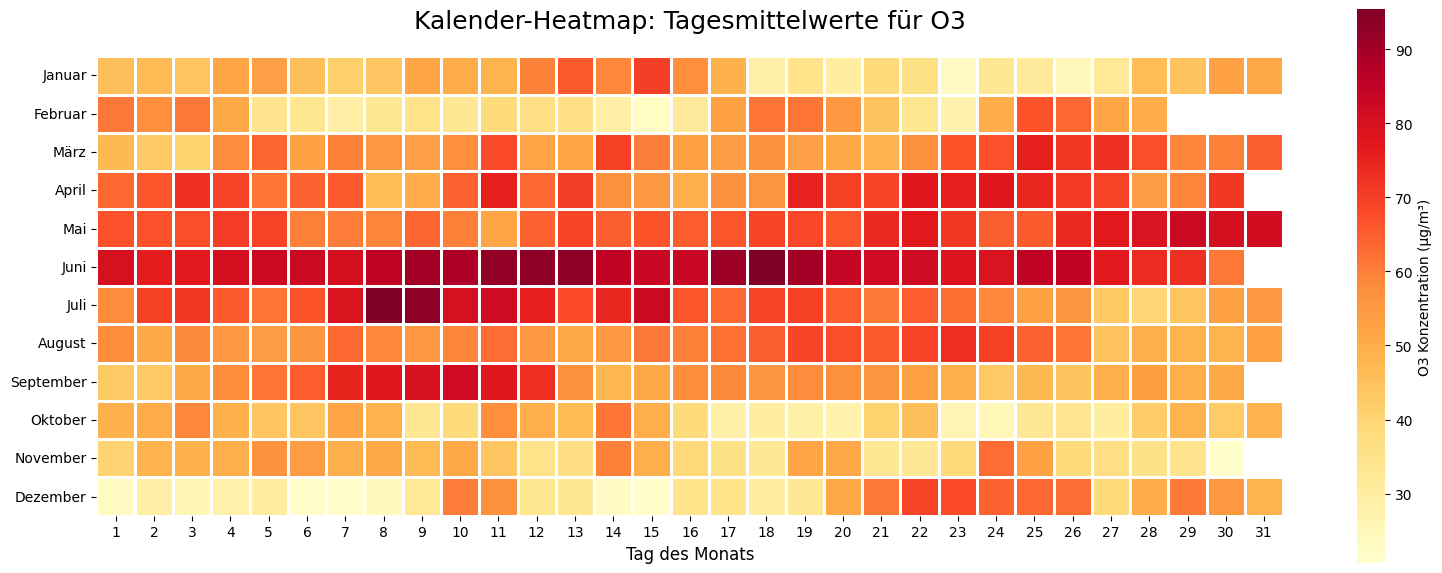

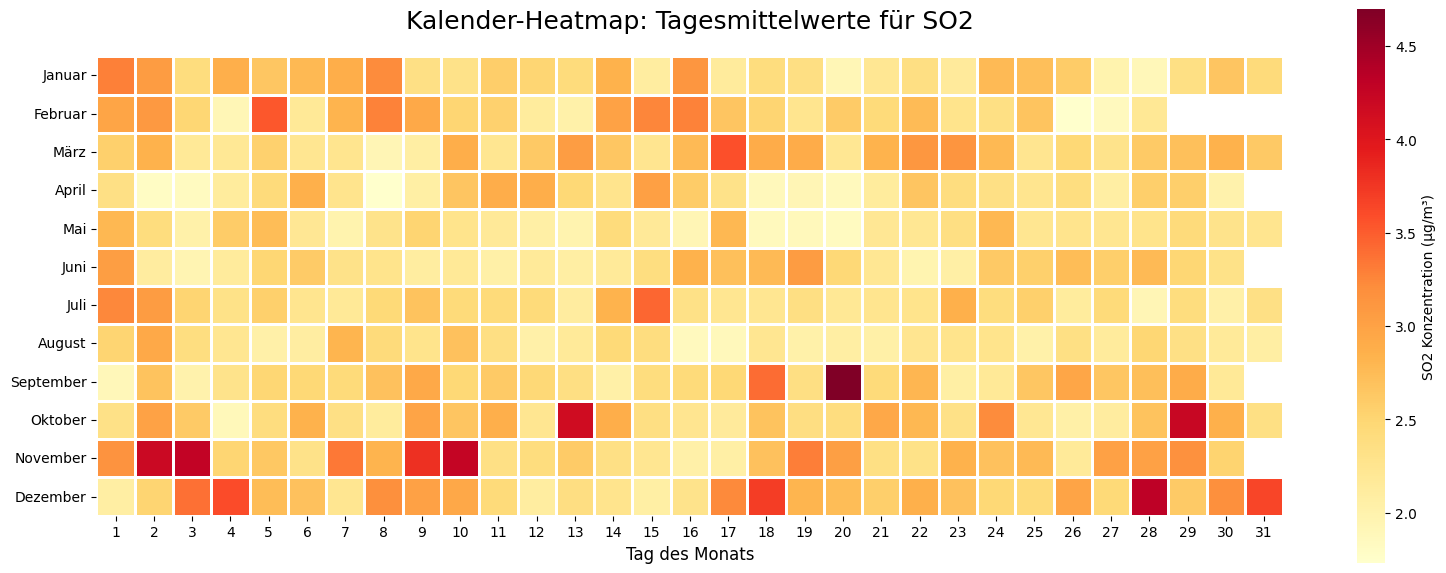

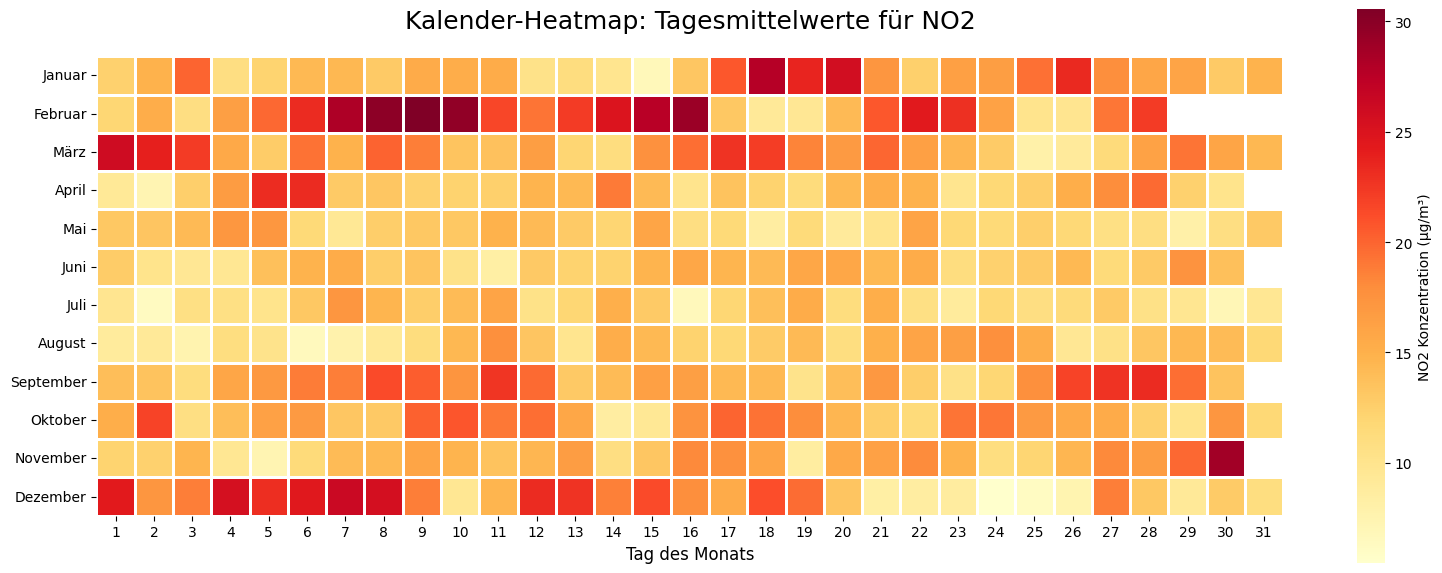

In [15]:
# ==========================================
# 2. SCHLEIFE FÜR DIE GRAFIKEN
# ==========================================
# Wir gehen jeden Schadstoff in der Liste durch
for pollutant in pollutant_cols:
    
    # Sicherheitscheck: Sind überhaupt Daten für diesen Schadstoff vorhanden?
    if daily_data[pollutant].isna().all():
        print(f"⚠️ Überspringe {pollutant.upper()}: Keine gültigen Daten vorhanden.")
        continue # Geht direkt zum nächsten Schadstoff in der Schleife
        
    # Erstelle die Pivot-Tabelle speziell für den aktuellen Schadstoff
    heatmap_data = daily_data.pivot(index="Monat", columns="Tag", values=pollutant)
    
    # Setze die Monatsnamen als Y-Achsen-Beschriftung
    heatmap_data.index = heatmap_data.index.map(monatsnamen)

    # Erstelle eine neue Figur für jeden Schadstoff
    plt.figure(figsize=(16, 6))

    # Zeichne die Heatmap
    sns.heatmap(
        heatmap_data, 
        cmap="YlOrRd",         
        linewidths=2,
        linecolor="white",
        square=True,
        cbar_kws={"label": f"{pollutant.upper()} Konzentration (µg/m³)"},
        annot=False            
    )

    # Titel und Achsen anpassen
    plt.title(f"Kalender-Heatmap: Tagesmittelwerte für {pollutant.upper()}", fontsize=18, pad=20)
    plt.xlabel("Tag des Monats", fontsize=12)
    plt.ylabel("", fontsize=12) 
    
    # X-Achsen-Beschriftung horizontal lassen
    plt.xticks(rotation=0)

    # Layout optimieren
    plt.tight_layout()

    # Grafik anzeigen
    plt.show()